In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import joblib

TRAIN_CSV = r"C:\Users\Taizeen\Downloads\data science assignments\Logistic Regression\Logistic Regression\Titanic_train.csv"
TEST_CSV = r"C:\Users\Taizeen\Downloads\data science assignments\Logistic Regression\Logistic Regression\Titanic_test.csv"
OUT_DIR = "titanic_results"
os.makedirs(OUT_DIR, exist_ok=True)


In [26]:
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
display(train.head())
display(test.head())
# Save quick previews
train.head(10).to_csv(os.path.join(OUT_DIR, "train_head_preview.csv"), index=False)
test.head(10).to_csv(os.path.join(OUT_DIR, "test_head_preview.csv"), index=False)


Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Train nulls:
 Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64
Test nulls:
 Cabin          327
Age             86
Fare             1
Name             0
Pclass           0
PassengerId      0
Sex              0
Parch            0
SibSp            0
Ticket           0
Embarked         0
dtype: int64


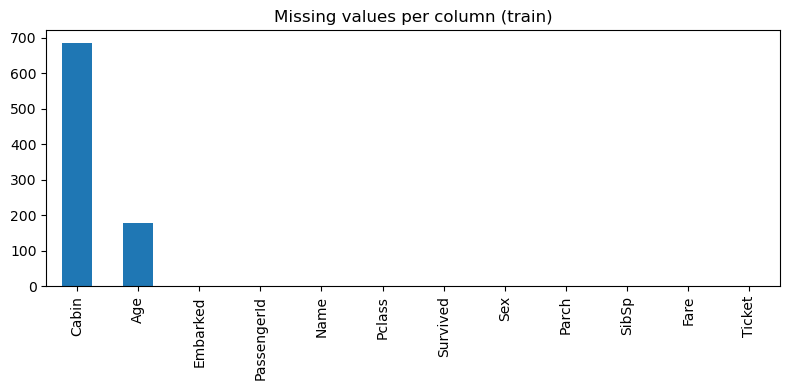

In [27]:
nulls_train = train.isnull().sum().sort_values(ascending=False)
nulls_test = test.isnull().sum().sort_values(ascending=False)
print("Train nulls:\n", nulls_train)
print("Test nulls:\n", nulls_test)

plt.figure(figsize=(8,4))
nulls_train.plot(kind='bar')
plt.title("Missing values per column (train)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "missing_values_train.png"))
plt.show()


In [28]:
def extract_title(name):
    if pd.isna(name):
        return "Unknown"
    if ',' in name and '.' in name:
        try:
            return name.split(',')[1].split('.')[0].strip()
        except:
            return "Unknown"
    return "Unknown"

for df in (train, test):
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss')
    df['Title'] = df['Title'].replace(['Mme'],'Mrs')
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['CabinKnown'] = (~df['Cabin'].isnull()).astype(int)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

overall_age_median = train['Age'].median()
title_age_medians = train.groupby('Title')['Age'].median().to_dict()
for df in (train, test):
    df['Age'] = df.apply(lambda r: title_age_medians.get(r['Title'], overall_age_median) if pd.isnull(r['Age']) else r['Age'], axis=1)
    df['Age'] = df['Age'].fillna(overall_age_median)

display(train[['Title','FamilySize','IsAlone','CabinKnown','Age']].head())


,Title,FamilySize,IsAlone,CabinKnown,Age
0,Mr,2,0,0,22.0
1,Mrs,2,0,1,38.0
2,Miss,1,1,0,26.0
3,Mrs,2,0,1,35.0
4,Mr,1,1,0,35.0


In [29]:
drop_cols = ['PassengerId','Name','Ticket','Cabin']
X = train.drop(columns=['Survived'] + drop_cols)
y = train['Survived'].copy()
X_test = test.drop(columns=drop_cols, errors='ignore')

numeric_features = ['Age','SibSp','Parch','Fare','FamilySize']
categorical_features = ['Pclass','Sex','Embarked','Title','CabinKnown','IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [30]:
log_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
rf_pipe  = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42))])
gb_pipe  = Pipeline([('pre', preprocessor), ('clf', GradientBoostingClassifier(random_state=42))])

param_log = {'clf__C': [0.1, 1.0, 10.0]}
param_rf  = {'clf__n_estimators':[50,100], 'clf__max_depth':[5, 10, None]}
param_gb  = {'clf__n_estimators':[50,100], 'clf__learning_rate':[0.05,0.1]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [31]:
gs_log = GridSearchCV(log_pipe, param_log, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_rf  = GridSearchCV(rf_pipe, param_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gs_gb  = GridSearchCV(gb_pipe, param_gb, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

print("Fitting LogisticRegression grid...")
gs_log.fit(X, y)
print("Fitting RandomForest grid...")
gs_rf.fit(X, y)
print("Fitting GradientBoosting grid...")
gs_gb.fit(X, y)

report = {
    'log_best_params': gs_log.best_params_,
    'log_best_cv_roc': float(gs_log.best_score_),
    'rf_best_params': gs_rf.best_params_,
    'rf_best_cv_roc': float(gs_rf.best_score_),
    'gb_best_params': gs_gb.best_params_,
    'gb_best_cv_roc': float(gs_gb.best_score_),
}
print(json.dumps(report, indent=2))
with open(os.path.join(OUT_DIR, 'grid_report.json'), 'w') as f:
    json.dump(report, f, indent=2)


Fitting LogisticRegression grid...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting RandomForest grid...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting GradientBoosting grid...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
{
  "log_best_params": {
    "clf__C": 1.0
  },
  "log_best_cv_roc": 0.8737171747982654,
  "rf_best_params": {
    "clf__max_depth": 10,
    "clf__n_estimators": 50
  },
  "rf_best_cv_roc": 0.87538566523538,
  "gb_best_params": {
    "clf__learning_rate": 0.1,
    "clf__n_estimators": 100
  },
  "gb_best_cv_roc": 0.8756920391175653
}


In [32]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_log = gs_log.best_estimator_
best_rf  = gs_rf.best_estimator_
best_gb  = gs_gb.best_estimator_

for name, model in [('Logistic', best_log), ('RandomForest', best_rf), ('GradientBoosting', best_gb)]:
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:,1]
    print(f"{name} - Acc: {accuracy_score(y_val,preds):.4f}, ROC AUC: {roc_auc_score(y_val,probs):.4f}")
    print(classification_report(y_val, preds))


Logistic - Acc: 0.8492, ROC AUC: 0.8866
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

RandomForest - Acc: 0.9274, ROC AUC: 0.9722
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       110
           1       0.95      0.86      0.90        69

    accuracy                           0.93       179
   macro avg       0.93      0.91      0.92       179
weighted avg       0.93      0.93      0.93       179

GradientBoosting - Acc: 0.8939, ROC AUC: 0.9499
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       110
           1       0.92      0.80      0.85        69

    accuracy                           0.89       

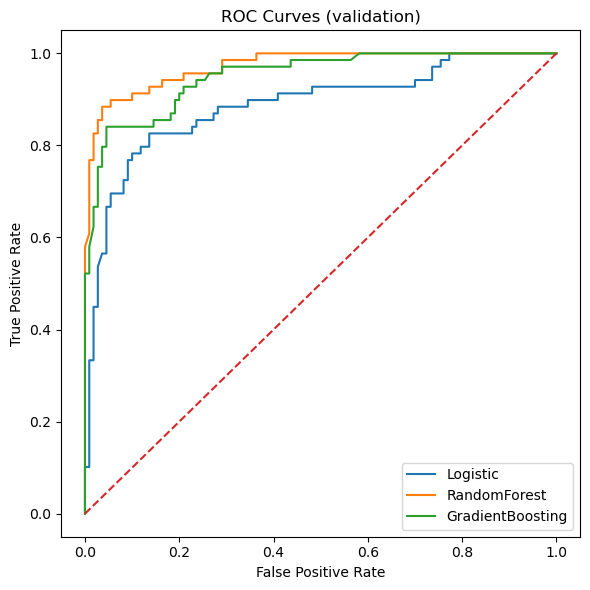

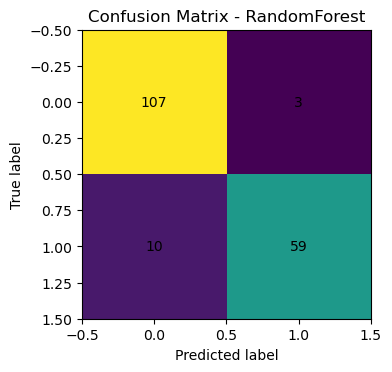

Best validation model: RandomForest ROC: 0.9722002635046114


In [33]:
plt.figure(figsize=(6,6))
for model, label in [(best_log,'Logistic'), (best_rf,'RandomForest'), (best_gb,'GradientBoosting')]:
    probs = model.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, probs)
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (validation)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"roc_curves.png"))
plt.show()

val_rocs = {
    'Logistic': roc_auc_score(y_val, best_log.predict_proba(X_val)[:,1]),
    'RandomForest': roc_auc_score(y_val, best_rf.predict_proba(X_val)[:,1]),
    'GradientBoosting': roc_auc_score(y_val, best_gb.predict_proba(X_val)[:,1])
}
best_name = max(val_rocs, key=val_rocs.get)
best_model = {'Logistic':best_log, 'RandomForest':best_rf, 'GradientBoosting':best_gb}[best_name]
cm = confusion_matrix(y_val, best_model.predict(X_val))

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('True label')
plt.xlabel('Predicted label')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"confusion_matrix.png"))
plt.show()

print("Best validation model:", best_name, "ROC:", val_rocs[best_name])


In [34]:
voting = VotingClassifier(estimators=[('log', best_log), ('rf', best_rf), ('gb', best_gb)], voting='soft', n_jobs=-1)
voting.fit(X_tr, y_tr)

v_preds = voting.predict(X_val)
v_probs = voting.predict_proba(X_val)[:,1]
print("Ensemble validation - Acc:", accuracy_score(y_val, v_preds), "ROC AUC:", roc_auc_score(y_val, v_probs))

test_preds = voting.predict(X_test)
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': test_preds})
submission_path = os.path.join(OUT_DIR, "submission_ensemble.csv")
submission.to_csv(submission_path, index=False)
print("Saved submission to:", submission_path)
display(submission.head())

joblib.dump(best_log, os.path.join(OUT_DIR, "best_log.joblib"))
joblib.dump(best_rf, os.path.join(OUT_DIR, "best_rf.joblib"))
joblib.dump(best_gb, os.path.join(OUT_DIR, "best_gb.joblib"))
joblib.dump(voting, os.path.join(OUT_DIR, "ensemble.joblib"))

final_report = {
    "grid_report": report,
    "validation_rocs": val_rocs,
    "best_validation_model": best_name,
    "ensemble_validation_roc": float(roc_auc_score(y_val, v_probs))
}
with open(os.path.join(OUT_DIR, "final_report.json"), "w") as f:
    json.dump(final_report, f, indent=2)

print("All outputs saved in folder:", OUT_DIR)
print("Files in folder:", os.listdir(OUT_DIR))


Ensemble validation - Acc: 0.8268156424581006 ROC AUC: 0.8561264822134387
Saved submission to: titanic_results\submission_ensemble.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


All outputs saved in folder: titanic_results
Files in folder: ['best_gb.joblib', 'best_log.joblib', 'best_rf.joblib', 'confusion_matrix.png', 'ensemble.joblib', 'final_report.json', 'grid_report.json', 'missing_values_train.png', 'roc_curves.png', 'submission_ensemble.csv', 'test_head_preview.csv', 'train_head_preview.csv']
